# 03__TF_expr

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def is_sig(row):
    if row["adj.P.Val"] < 0.01 and np.abs(row["logFC"]) >= 1:
        return "sig"
    else:
        return "not sig"

## variables

In [5]:
hESC_expr_f = "../../../data/03__rna_seq/00__HUES64/02__tpms/hESC.tpm.txt"
mESC_expr_f = "../../../data/03__rna_seq/01__mESC/02__tpms/mESC.tpm.txt"
orth_expr_f = "../../../data/03__rna_seq/02__orths/02__tpms/orth.tpm.txt"
orth_de_f = "../../../data/03__rna_seq/03__DE/orth.voom.tt_table.with_interaction.txt"

In [6]:
orth_f = "../../../misc/00__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"
human_gene_map_f = "../../../misc/00__ensembl_orthologs/gencode.v25lift37.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"
mouse_gene_map_f = "../../../misc/00__ensembl_orthologs/gencode.vM13.GENE_ID_TO_NAME_AND_BIOTYPE_MAP.txt"

In [7]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

## 1. import data

In [8]:
hESC_expr = pd.read_table(hESC_expr_f).reset_index()
mESC_expr = pd.read_table(mESC_expr_f).reset_index()
hESC_expr.head()

,index,rep1,rep2,rep3
0,ENSG00000223972,0.000000,0.00000,0.00000
1,ENSG00000227232,353.570372,427.66079,297.04687
2,ENSG00000243485,0.000000,0.00000,0.93411
3,ENSG00000237613,0.000000,0.00000,0.00000
4,ENSG00000268020,0.000000,0.00000,0.00000


In [9]:
orth_expr = pd.read_table(orth_expr_f).reset_index()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,hESC_rep3,mESC_rep1,mESC_rep2,mESC_rep3
0,ENSG00000187961__ENSMUSG00000078485,399.234542,455.690063,238.068316,163.467520,86.627332,150.107729
1,ENSG00000187642__ENSMUSG00000078486,5.444107,12.439815,9.769542,17.768209,5.197640,16.511850
2,ENSG00000187608__ENSMUSG00000035692,873.476786,672.404734,385.125634,522.385336,119.545719,97.570024
3,ENSG00000188157__ENSMUSG00000041936,5409.023143,7552.277124,5114.098201,12745.136106,9277.787308,9653.428026
4,ENSG00000131591__ENSMUSG00000059939,284.303386,340.458093,234.469011,1515.628203,1217.980295,1541.606373


In [10]:
orth_de = pd.read_table(orth_de_f).reset_index()
orth_de.head()

,index,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,ENSG00000115112__ENSMUSG00000026380,7.148172,7.181576,52.484380,6.474120e-17,1.738140e-13,28.492610
1,ENSG00000188375__ENSMUSG00000016559,6.430191,5.983091,50.224258,1.164959e-16,1.738140e-13,27.766366
2,ENSG00000087303__ENSMUSG00000021806,5.482785,6.100495,45.308138,4.601763e-16,2.811307e-13,26.784354
3,ENSG00000035403__ENSMUSG00000021823,-4.477505,8.112172,-43.181383,8.732277e-16,3.149889e-13,26.405724
4,ENSG00000161960__ENSMUSG00000059796,8.172684,6.797219,44.219706,6.362871e-16,2.852655e-13,26.360066


In [11]:
orth = pd.read_table(orth_f)
orth.head()

,Gene stable ID,Transcript stable ID,Gene name,Mouse gene stable ID,Mouse protein or transcript stable ID,Mouse gene name,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,dN with Mouse,dS with Mouse,"Mouse orthology confidence [0 low, 1 high]",Mouse homology type
0,ENSG00000198888,ENST00000361390,MT-ND1,ENSMUSG00000064341,ENSMUSP00000080991,mt-Nd1,77.0440,77.0440,NaN,NaN,1.0,ortholog_one2one
1,ENSG00000198763,ENST00000361453,MT-ND2,ENSMUSG00000064345,ENSMUSP00000080992,mt-Nd2,57.0605,57.3913,NaN,NaN,1.0,ortholog_one2one
2,ENSG00000198804,ENST00000361624,MT-CO1,ENSMUSG00000064351,ENSMUSP00000080993,mt-Co1,90.8382,90.6615,NaN,NaN,1.0,ortholog_one2one
3,ENSG00000198712,ENST00000361739,MT-CO2,ENSMUSG00000064354,ENSMUSP00000080994,mt-Co2,71.3656,71.3656,NaN,NaN,1.0,ortholog_one2one
4,ENSG00000228253,ENST00000361851,MT-ATP8,ENSMUSG00000064356,ENSMUSP00000080995,mt-Atp8,45.5882,46.2687,0.49,0.85,0.0,ortholog_one2one


In [12]:
human_gene_map = pd.read_table(human_gene_map_f, header=None)
human_gene_map.columns = ["gene_id", "biotype", "gene_name"]
human_gene_map.head()

,gene_id,biotype,gene_name
0,ENSG00000223972.5_1,transcribed_unprocessed_pseudogene,DDX11L1
1,ENSG00000227232.5_1,unprocessed_pseudogene,WASH7P
2,ENSG00000243485.4_2,lincRNA,MIR1302-2
3,ENSG00000237613.2_1,lincRNA,FAM138A
4,ENSG00000268020.3_1,unprocessed_pseudogene,OR4G4P


In [13]:
mouse_gene_map = pd.read_table(mouse_gene_map_f, header=None)
mouse_gene_map.columns = ["gene_id", "biotype", "gene_name"]
mouse_gene_map.head()

,gene_id,biotype,gene_name
0,ENSMUSG00000102693.1,TEC,4933401J01Rik
1,ENSMUSG00000064842.1,snRNA,Gm26206
2,ENSMUSG00000051951.5,protein_coding,Xkr4
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
4,ENSMUSG00000103377.1,TEC,Gm37180


In [14]:
motif_info = pd.read_table(motif_info_f)
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [15]:
motif_info["short_id"] = motif_info["CIS-BP ID"].str.split(".", expand=True)[0]
motif_info = motif_info[motif_info["Best Motif(s)? (Figure 2A)"] == True]
motif_map = motif_info[["short_id","Ensembl ID", "HGNC symbol"]]
motif_map.columns = ["index", "gene_id", "gene_name"]
motif_map = motif_map.sort_values(by="index")
print(len(motif_map))
motif_map.head()

1496


,index,gene_id,gene_name
8042,HKR1,ENSG00000181666,HKR1
590,M00140_1,ENSG00000179361,ARID3B
603,M00142_1,ENSG00000205143,ARID3C
574,M00142_1,ENSG00000116017,ARID3A
619,M00143_1,ENSG00000150347,ARID5B


In [16]:
motif_map[motif_map["gene_name"] == "ASCL2"]

,index,gene_id,gene_name
906,M08476_1,ENSG00000183734,ASCL2


## 2. do some QC on RNA-seq

In [17]:
human_gene_map["index"] = human_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map["index"] = mouse_gene_map["gene_id"].str.split(".", expand=True)[0]
mouse_gene_map.head()

,gene_id,biotype,gene_name,index
0,ENSMUSG00000102693.1,TEC,4933401J01Rik,ENSMUSG00000102693
1,ENSMUSG00000064842.1,snRNA,Gm26206,ENSMUSG00000064842
2,ENSMUSG00000051951.5,protein_coding,Xkr4,ENSMUSG00000051951
3,ENSMUSG00000102851.1,processed_pseudogene,Gm18956,ENSMUSG00000102851
4,ENSMUSG00000103377.1,TEC,Gm37180,ENSMUSG00000103377


In [18]:
hESC_expr = hESC_expr.merge(human_gene_map, on="index", how="left")
hESC_expr.sample(5)

,index,rep1,rep2,rep3,gene_id,biotype,gene_name
920,ENSG00000223062,0.000000,0.000000,0.000000,ENSG00000223062.1,snRNA,RNU6-1245P
35817,ENSG00000254626,0.000000,0.000000,0.000000,ENSG00000254626.1_1,lincRNA,RP11-27G22.1
10628,ENSG00000242960,15.109845,26.140635,27.089180,ENSG00000242960.1_1,processed_pseudogene,FTH1P23
44261,ENSG00000260608,2.014646,1.045625,7.472877,ENSG00000260608.1_2,antisense,RP11-382A20.7
4086,ENSG00000264809,0.000000,0.000000,0.000000,ENSG00000264809.1,miRNA,AL513344.1


In [19]:
mESC_expr = mESC_expr.merge(mouse_gene_map, on="index", how="left")
mESC_expr.sample(5)

,index,rep1,rep2,rep3,gene_id,biotype,gene_name
3433,ENSMUSG00000074309,0.000000,0.000000,0.000000,NaN,NaN,NaN
4299,ENSMUSG00000075886,0.000000,0.000000,0.000000,NaN,NaN,NaN
15222,ENSMUSG00000077650,0.000000,0.000000,0.000000,ENSMUSG00000077650.1,snoRNA,Gm23320
1452,ENSMUSG00000029787,909.395601,1156.926236,1234.084657,ENSMUSG00000029787.10,protein_coding,Avl9
26034,ENSMUSG00000024436,1047.182813,912.490613,829.304890,ENSMUSG00000024436.16,protein_coding,Mrps18b


In [20]:
human_genes_to_check = ["XIST", "SRY", "RPS4Y1", "DDX3Y", "POU5F1", "NANOG", "SOX2", "EOMES", "SOX17", "FOXA2"]

In [21]:
human_sub = hESC_expr[hESC_expr["gene_name"].isin(human_genes_to_check)]
human_sub = pd.melt(human_sub[["gene_name", "rep1", "rep2", "rep3"]], id_vars="gene_name")
human_sub.head()

,gene_name,variable,value
0,EOMES,rep1,9.065907
1,SOX2,rep1,8313.436692
2,POU5F1,rep1,4706.213041
3,XIST,rep1,6.043938
4,SOX17,rep1,1.007323


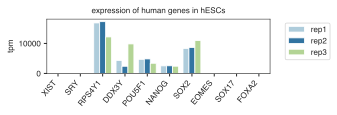

In [22]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=human_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=human_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(human_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of human genes in hESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [23]:
mouse_genes_to_check = ["Xist", "Sry", "Eif2s3y", "Ddx3y", "Pou5f1", "Nanog", "Sox2", "Eomes", "Sox17", "Foxa2"]

In [24]:
mouse_sub = mESC_expr[mESC_expr["gene_name"].isin(mouse_genes_to_check)]
mouse_sub = pd.melt(mouse_sub[["gene_name", "rep1", "rep2", "rep3"]], id_vars="gene_name")
mouse_sub.head()

,gene_name,variable,value
0,Nanog,rep1,13577.339914
1,Sox17,rep1,4.239607
2,Xist,rep1,9.539115
3,Eomes,rep1,316.910588
4,Sox2,rep1,8294.790177


In [25]:
mouse_sub.gene_name.unique()

array(['Nanog', 'Sox17', 'Xist', 'Eomes', 'Sox2', 'Pou5f1', 'Foxa2',
       'Eif2s3y', 'Ddx3y', 'Sry'], dtype=object)

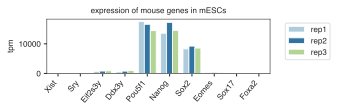

In [26]:
fig = plt.figure(figsize=(4, 1))

ax = sns.barplot(data=mouse_sub, x="gene_name", y="value", hue="variable", palette="Paired", 
                 order=mouse_genes_to_check)
#ax.set_yscale('symlog')
ax.set_xticklabels(mouse_genes_to_check, va="top", ha="right", rotation=50)
ax.set_ylabel("tpm")
ax.set_title("expression of mouse genes in mESCs")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

## 3. look at expression of TFs in hESCs

In [27]:
uniq_human_TFs = motif_map["gene_name"].unique()
print(len(uniq_human_TFs))

TFs_in_seq = [x for x in uniq_human_TFs if x in list(hESC_expr["gene_name"])]
print(len(TFs_in_seq))

TFs_missing = [x for x in uniq_human_TFs if x not in list(hESC_expr["gene_name"])]
print(len(TFs_missing))

1208
1195
13


In [28]:
TFs_missing

['SEBOX',
 'NR2E3',
 'DUX4',
 'DUX1',
 'DUX3',
 'ZNF658',
 'ZNF883',
 'HNF1B',
 'AC023509.3',
 'LHX1',
 'AC138696.1',
 'ZSCAN5C',
 'ZNF2']

the above TFs are missing from the RNA-seq so will not be included (I hand checked a few and couldn't find easy aliases, might look more later)

In [29]:
hESC_TFs = hESC_expr[hESC_expr["gene_name"].isin(uniq_human_TFs)].drop_duplicates(subset=["index", "rep1", "rep2", "rep3",
                                                                                          "biotype", "gene_name"])
print(len(hESC_TFs))
hESC_TFs.head()

1196


,index,rep1,rep2,rep3,gene_id,biotype,gene_name
71,ENSG00000188290,13.095199,11.501879,6.538768,ENSG00000188290.10_1,protein_coding,HES4
172,ENSG00000197921,1.007323,4.182502,2.802329,ENSG00000197921.5_1,protein_coding,HES5
187,ENSG00000142611,73.534579,51.235645,42.034934,ENSG00000142611.16_2,protein_coding,PRDM16
197,ENSG00000078900,116.849468,153.706934,83.135759,ENSG00000078900.14_2,protein_coding,TP73
234,ENSG00000173673,235.713581,323.098250,257.814264,ENSG00000173673.7_1,protein_coding,HES3


In [30]:
tmp = hESC_TFs.groupby("gene_name")["index"].agg("count").reset_index()
tmp.sort_values(by="index", ascending=False).head()

,gene_name,index
1127,ZNF727,2
0,AHR,1
794,UBP1,1
801,VENTX,1
800,VDR,1


one of these TFs have multiple gene_ids (probably from using the lifted gencode v25 instead of gencode v25 in hg38). manually fix this guy

In [31]:
hESC_TFs = hESC_TFs[hESC_TFs["index"] != "ENSG00000273439"]
len(hESC_TFs)

1195

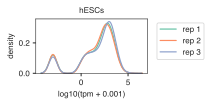

In [32]:
fig = plt.figure(figsize=(2, 1))

ax = sns.distplot(np.log10(hESC_TFs["rep1"]+0.001), label="rep 1", color=sns.color_palette("Set2")[0], hist=False)
sns.distplot(np.log10(hESC_TFs["rep2"]+0.001), label="rep 2", color=sns.color_palette("Set2")[1], hist=False)
sns.distplot(np.log10(hESC_TFs["rep3"]+0.001), label="rep 3", color=sns.color_palette("Set2")[2], hist=False)

ax.set_xlabel("log10(tpm + 0.001)")
ax.set_ylabel("density")
ax.set_title("hESCs")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

In [33]:
hESC_TFs["mean_tpm"] = hESC_TFs[["rep1", "rep2", "rep3"]].mean(axis=1)
hESC_TFs.head()

,index,rep1,rep2,rep3,gene_id,biotype,gene_name,mean_tpm
71,ENSG00000188290,13.095199,11.501879,6.538768,ENSG00000188290.10_1,protein_coding,HES4,10.378615
172,ENSG00000197921,1.007323,4.182502,2.802329,ENSG00000197921.5_1,protein_coding,HES5,2.664051
187,ENSG00000142611,73.534579,51.235645,42.034934,ENSG00000142611.16_2,protein_coding,PRDM16,55.601719
197,ENSG00000078900,116.849468,153.706934,83.135759,ENSG00000078900.14_2,protein_coding,TP73,117.897387
234,ENSG00000173673,235.713581,323.098250,257.814264,ENSG00000173673.7_1,protein_coding,HES3,272.208698


In [34]:
hESC_TFs_expr = list(hESC_TFs[hESC_TFs["mean_tpm"] > 1]["gene_name"])
len(hESC_TFs_expr)

1020

## 4. look at expression of orthologous TFs in mouse

In [35]:
human_mouse_TFs = hESC_TFs[["index", "gene_name", "mean_tpm"]]
print(len(human_mouse_TFs))
human_mouse_TFs = human_mouse_TFs.merge(orth[["Gene stable ID", 
                                              "Mouse gene stable ID", 
                                              "Gene name",
                                              "Mouse gene name"]].drop_duplicates(),
                                        left_on=["index", "gene_name"],
                                        right_on=["Gene stable ID", "Gene name"])
human_mouse_TFs.drop(["Gene stable ID", "Gene name"], axis=1, inplace=True)
human_mouse_TFs.columns = ["gene_id_human", "gene_name_human", "mean_tpm_human", "gene_id_mouse", "gene_name_mouse"]
print(len(human_mouse_TFs))
human_mouse_TFs.head()

1195
1086


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse
0,ENSG00000197921,HES5,2.664051,ENSMUSG00000048001,Hes5
1,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16
2,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73
3,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3
4,ENSG00000069812,HES2,12.847431,ENSMUSG00000028940,Hes2


In [36]:
mESC_expr["mean_tpm_mouse"] = mESC_expr[["rep1", "rep2", "rep3"]].mean(axis=1)
mESC_expr.head()

,index,rep1,rep2,rep3,gene_id,biotype,gene_name,mean_tpm_mouse
0,ENSMUSG00000000702,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
1,ENSMUSG00000078423,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
2,ENSMUSG00000078424,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
3,ENSMUSG00000071964,2.119803,0.0,0.000000,NaN,NaN,NaN,0.706601
4,ENSMUSG00000093774,0.000000,0.0,4.487581,ENSMUSG00000093774.1,unprocessed_pseudogene,Vmn1r-ps151,1.495860


In [37]:
human_mouse_TFs = human_mouse_TFs.merge(mESC_expr[["index", "gene_name", "mean_tpm_mouse"]],
                                        left_on=["gene_id_mouse", "gene_name_mouse"],
                                        right_on=["index", "gene_name"])
human_mouse_TFs.drop(["index", "gene_name"], axis=1, inplace=True)
print(len(human_mouse_TFs))
human_mouse_TFs.head()

1032


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
0,ENSG00000197921,HES5,2.664051,ENSMUSG00000048001,Hes5,0.000000
1,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16,612.953260
2,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73,239.674040
3,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000
4,ENSG00000069812,HES2,12.847431,ENSMUSG00000028940,Hes2,1.949365


In [38]:
human_mouse_TFs[human_mouse_TFs["gene_name_mouse"] == "Zfy2"]

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
889,ENSG00000171469,ZNF561,3182.793224,ENSMUSG00000000103,Zfy2,0.0
890,ENSG00000171466,ZNF562,1507.228348,ENSMUSG00000000103,Zfy2,0.0
891,ENSG00000180884,ZNF792,376.885200,ENSMUSG00000000103,Zfy2,0.0
892,ENSG00000188227,ZNF793,640.945560,ENSMUSG00000000103,Zfy2,0.0
893,ENSG00000198464,ZNF480,1331.634032,ENSMUSG00000000103,Zfy2,0.0
894,ENSG00000167554,ZNF610,152.031196,ENSMUSG00000000103,Zfy2,0.0
895,ENSG00000131845,ZNF304,896.766293,ENSMUSG00000000103,Zfy2,0.0
896,ENSG00000188785,ZNF548,399.018642,ENSMUSG00000000103,Zfy2,0.0
897,ENSG00000105136,ZNF419,562.536719,ENSMUSG00000000103,Zfy2,0.0
898,ENSG00000121406,ZNF549,853.335795,ENSMUSG00000000103,Zfy2,0.0


In [39]:
mESC_TFs_expr = list(human_mouse_TFs[human_mouse_TFs["mean_tpm_mouse"] > 1]["gene_name_mouse"].unique())
len(mESC_TFs_expr)

806

## 5. look at orthologous expression

In [40]:
orth_expr["gene_id_human"] = orth_expr["index"].str.split("__", expand=True)[0]
orth_expr["gene_id_mouse"] = orth_expr["index"].str.split("__", expand=True)[1]
orth_expr.head()

,index,hESC_rep1,hESC_rep2,hESC_rep3,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse
0,ENSG00000187961__ENSMUSG00000078485,399.234542,455.690063,238.068316,163.467520,86.627332,150.107729,ENSG00000187961,ENSMUSG00000078485
1,ENSG00000187642__ENSMUSG00000078486,5.444107,12.439815,9.769542,17.768209,5.197640,16.511850,ENSG00000187642,ENSMUSG00000078486
2,ENSG00000187608__ENSMUSG00000035692,873.476786,672.404734,385.125634,522.385336,119.545719,97.570024,ENSG00000187608,ENSMUSG00000035692
3,ENSG00000188157__ENSMUSG00000041936,5409.023143,7552.277124,5114.098201,12745.136106,9277.787308,9653.428026,ENSG00000188157,ENSMUSG00000041936
4,ENSG00000131591__ENSMUSG00000059939,284.303386,340.458093,234.469011,1515.628203,1217.980295,1541.606373,ENSG00000131591,ENSMUSG00000059939


In [41]:
orth_sub = orth[["Gene stable ID", "Mouse gene stable ID", "Gene name", "Mouse gene name"]].drop_duplicates()
orth_sub.columns = ["gene_id_human", "gene_id_mouse", "gene_name_human", "gene_name_mouse"]
orth_expr = orth_expr.merge(orth_sub, on=["gene_id_human", "gene_id_mouse"]).drop_duplicates()
orth_expr.head()

,index,hESC_rep1,hESC_rep2,hESC_rep3,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse
0,ENSG00000187961__ENSMUSG00000078485,399.234542,455.690063,238.068316,163.467520,86.627332,150.107729,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1
1,ENSG00000187642__ENSMUSG00000078486,5.444107,12.439815,9.769542,17.768209,5.197640,16.511850,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1
2,ENSG00000187608__ENSMUSG00000035692,873.476786,672.404734,385.125634,522.385336,119.545719,97.570024,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15
3,ENSG00000188157__ENSMUSG00000041936,5409.023143,7552.277124,5114.098201,12745.136106,9277.787308,9653.428026,ENSG00000188157,ENSMUSG00000041936,AGRN,Agrn
4,ENSG00000131591__ENSMUSG00000059939,284.303386,340.458093,234.469011,1515.628203,1217.980295,1541.606373,ENSG00000131591,ENSMUSG00000059939,C1orf159,9430015G10Rik


In [42]:
orth_expr["mean_tpm_hESC"] = orth_expr[["hESC_rep1", "hESC_rep2", "hESC_rep3"]].mean(axis=1)
orth_expr["mean_tpm_mESC"] = orth_expr[["mESC_rep1", "mESC_rep2", "mESC_rep3"]].mean(axis=1)
orth_expr.head()

,index,hESC_rep1,hESC_rep2,hESC_rep3,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse,mean_tpm_hESC,mean_tpm_mESC
0,ENSG00000187961__ENSMUSG00000078485,399.234542,455.690063,238.068316,163.467520,86.627332,150.107729,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1,364.330974,133.400860
1,ENSG00000187642__ENSMUSG00000078486,5.444107,12.439815,9.769542,17.768209,5.197640,16.511850,ENSG00000187642,ENSMUSG00000078486,PERM1,Perm1,9.217821,13.159233
2,ENSG00000187608__ENSMUSG00000035692,873.476786,672.404734,385.125634,522.385336,119.545719,97.570024,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15,643.669051,246.500359
3,ENSG00000188157__ENSMUSG00000041936,5409.023143,7552.277124,5114.098201,12745.136106,9277.787308,9653.428026,ENSG00000188157,ENSMUSG00000041936,AGRN,Agrn,6025.132822,10558.783814
4,ENSG00000131591__ENSMUSG00000059939,284.303386,340.458093,234.469011,1515.628203,1217.980295,1541.606373,ENSG00000131591,ENSMUSG00000059939,C1orf159,9430015G10Rik,286.410163,1425.071623


In [43]:
print(len(orth_expr))
orth_expr = orth_expr.merge(orth_de, on="index")
print(len(orth_expr))
orth_expr.head()

18898
14068


,index,hESC_rep1,hESC_rep2,hESC_rep3,mESC_rep1,mESC_rep2,mESC_rep3,gene_id_human,gene_id_mouse,gene_name_human,gene_name_mouse,mean_tpm_hESC,mean_tpm_mESC,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,ENSG00000187961__ENSMUSG00000078485,399.234542,455.690063,238.068316,163.467520,86.627332,150.107729,ENSG00000187961,ENSMUSG00000078485,KLHL17,Plekhn1,364.330974,133.400860,-1.459686,2.853132,-4.206652,9.618684e-04,1.503507e-03,-1.356462
1,ENSG00000187608__ENSMUSG00000035692,873.476786,672.404734,385.125634,522.385336,119.545719,97.570024,ENSG00000187608,ENSMUSG00000035692,ISG15,Isg15,643.669051,246.500359,-1.784707,1.349707,-3.899005,1.731406e-03,2.604794e-03,-2.033226
2,ENSG00000188157__ENSMUSG00000041936,5409.023143,7552.277124,5114.098201,12745.136106,9277.787308,9653.428026,ENSG00000188157,ENSMUSG00000041936,AGRN,Agrn,6025.132822,10558.783814,0.781346,8.044454,4.412819,6.520208e-04,1.044005e-03,-1.435670
3,ENSG00000131591__ENSMUSG00000059939,284.303386,340.458093,234.469011,1515.628203,1217.980295,1541.606373,ENSG00000131591,ENSMUSG00000059939,C1orf159,9430015G10Rik,286.410163,1425.071623,2.296597,4.539635,12.873199,6.264528e-09,3.225819e-08,10.815455
4,ENSG00000186891__ENSMUSG00000041954,13.912719,22.260721,9.255356,46.197343,31.185840,36.025855,ENSG00000186891,ENSMUSG00000041954,TNFRSF18,Tnfrsf18,15.142932,37.803012,1.375744,-0.286124,3.751767,2.300126e-03,3.400039e-03,-1.834142


In [44]:
orth_expr["sig"] = orth_expr.apply(is_sig, axis=1)
orth_expr.sig.value_counts()

sig        8243
not sig    5825
Name: sig, dtype: int64

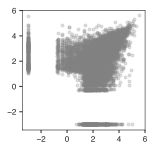

In [45]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(np.log10(orth_expr["mean_tpm_hESC"]+0.001), 
           np.log10(orth_expr["mean_tpm_mESC"]+0.001),
           color="gray", alpha=0.25, s=10, rasterized=True)

In [46]:
print(len(human_mouse_TFs))
orth_tf_expr = human_mouse_TFs.merge(orth_expr, on=["gene_id_human", "gene_name_human", 
                                                    "gene_id_mouse", "gene_name_mouse"]).drop_duplicates()
print(len(orth_tf_expr))
orth_tf_expr.head()

1032
714


,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,index,hESC_rep1,hESC_rep2,hESC_rep3,...,mESC_rep3,mean_tpm_hESC,mean_tpm_mESC,logFC,AveExpr,t,P.Value,adj.P.Val,B,sig
0,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16,612.953260,ENSG00000142611__ENSMUSG00000039410,44.157760,32.081628,23.138389,...,1152.827356,33.125926,1025.914477,4.964306,2.510447,21.322286,9.794898e-12,1.771139e-10,17.295409,sig
1,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73,239.674040,ENSG00000078900__ENSMUSG00000029026,70.168495,96.244884,45.762592,...,438.314568,70.725324,401.177928,2.552952,2.530112,10.079950,1.246188e-07,4.216300e-07,7.895139,sig
2,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000,ENSG00000173673__ENSMUSG00000028946,141.546792,202.310675,141.915454,...,0.000000,161.924307,0.000000,-7.611337,-1.119951,-21.550155,8.525795e-12,1.590728e-10,16.457825,sig
3,ENSG00000204859,ZBTB48,1251.437325,ENSMUSG00000028952,Zbtb48,342.804146,ENSG00000204859__ENSMUSG00000028952,770.038745,890.428859,577.945544,...,549.394287,746.137716,573.826255,-0.387987,4.430457,-2.202683,4.567163e-02,5.686419e-02,-5.435890,not sig
4,ENSG00000125945,ZNF436,136.434616,ENSMUSG00000051351,Zfp46,177.665949,ENSG00000125945__ENSMUSG00000051351,84.081214,83.805069,74.557032,...,255.183139,80.814438,297.414676,1.836888,2.222969,7.993100,1.840953e-06,4.656334e-06,5.112228,sig


In [47]:
orth_tf_expr = orth_tf_expr[["gene_id_human", "gene_name_human", "mean_tpm_human", "gene_id_mouse", "gene_name_mouse",
                             "mean_tpm_mouse", "AveExpr", "logFC", "adj.P.Val", "sig"]].drop_duplicates()
len(orth_tf_expr)

714

In [48]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_human")["gene_name_mouse"].agg("count").reset_index()
human_dupe_orths = tmp[tmp["gene_name_mouse"] > 1]
print(len(human_dupe_orths))
human_dupe_orths

8


,gene_name_human,gene_name_mouse
282,MTERF1,2
293,MYCN,2
600,ZNF274,2
612,ZNF34,26
636,ZNF519,2
641,ZNF566,2
647,ZNF627,2
667,ZNF780A,5


In [49]:
# remove any orth pair that maps to more than one gene
tmp = orth_tf_expr.groupby("gene_name_mouse")["gene_name_human"].agg("count").reset_index()
mouse_dupe_orths = tmp[tmp["gene_name_human"] > 1]
print(len(mouse_dupe_orths))
mouse_dupe_orths.head()

5


,gene_name_mouse,gene_name_human
304,Nanog,2
379,Pou5f1,2
432,Sohlh2,2
620,Zfp558,2
651,Zfp763,2


In [50]:
orth_tf_expr = orth_tf_expr[~orth_tf_expr["gene_name_human"].isin(human_dupe_orths["gene_name_human"])]
orth_tf_expr = orth_tf_expr[~orth_tf_expr["gene_name_mouse"].isin(mouse_dupe_orths["gene_name_mouse"])]
len(orth_tf_expr)

661

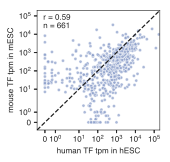

In [51]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

ax.scatter(orth_tf_expr["mean_tpm_human"], 
           orth_tf_expr["mean_tpm_mouse"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 200000], [-0.75, 200000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 200000))
ax.set_ylim((-0.75, 200000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_human"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mouse"]))]
r, p = spearmanr(no_nan["mean_tpm_human"], no_nan["mean_tpm_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "n = %s" % (len(no_nan)), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
fig.savefig("TF_human_v_mouse_scatter.pdf", dpi="figure", bbox_inches="tight")

In [52]:
orth_tf_expr["neg_log_padj"] = -np.log10(orth_tf_expr["adj.P.Val"])
orth_tf_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16,612.953260,2.510447,4.964306,1.771139e-10,sig,9.751747
1,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73,239.674040,2.530112,2.552952,4.216300e-07,sig,6.375069
2,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000,-1.119951,-7.611337,1.590728e-10,sig,9.798404
3,ENSG00000204859,ZBTB48,1251.437325,ENSMUSG00000028952,Zbtb48,342.804146,4.430457,-0.387987,5.686419e-02,not sig,1.245161
4,ENSG00000125945,ZNF436,136.434616,ENSMUSG00000051351,Zfp46,177.665949,2.222969,1.836888,4.656334e-06,sig,5.331956


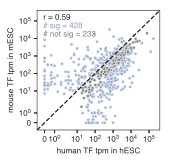

In [53]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig = orth_tf_expr[orth_tf_expr["sig"] == "sig"]
not_sig = orth_tf_expr[orth_tf_expr["sig"] == "not sig"]

ax.scatter(sig["mean_tpm_human"], 
           sig["mean_tpm_mouse"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")

ax.scatter(not_sig["mean_tpm_human"], 
           not_sig["mean_tpm_mouse"],
           color="gray", alpha=0.9, s=10, 
           linewidths=0.5, edgecolors="white")

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 400000], [-0.75, 400000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 400000))
ax.set_ylim((-0.75, 400000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_tf_expr[(~pd.isnull(orth_tf_expr["mean_tpm_human"])) & 
                      (~pd.isnull(orth_tf_expr["mean_tpm_mouse"]))]
r, p = spearmanr(no_nan["mean_tpm_human"], no_nan["mean_tpm_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "# sig = %s" % (len(sig)), ha="left", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2],
        transform=ax.transAxes)
ax.text(0.05, 0.83, "# not sig = %s" % (len(not_sig)), ha="left", va="top", fontsize=fontsize, color="gray",
        transform=ax.transAxes)
fig.savefig("TF_human_v_mouse_scatter.w_sig_outline.pdf", dpi="figure", bbox_inches="tight")

In [54]:
sig.sort_values(by="logFC", ascending=False).head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
174,ENSG00000204644,ZFP57,0.000000,ENSMUSG00000036036,Zfp57,8337.112594,1.588808,15.496843,1.420463e-13,sig,12.847570
713,ENSG00000263001,GTF2I,0.000000,ENSMUSG00000060261,Gtf2i,3626.282029,0.858439,14.290109,3.106984e-13,sig,12.507661
180,ENSG00000204231,RXRB,0.000000,ENSMUSG00000039656,Rxrb,771.697879,-0.225392,12.063611,3.917165e-13,sig,12.407028
177,ENSG00000204366,ZBTB12,0.000000,ENSMUSG00000049823,Zbtb12,717.421234,-0.231648,11.955539,4.970893e-13,sig,12.303566
178,ENSG00000213676,ATF6B,0.671549,ENSMUSG00000015461,Atf6b,1084.318139,0.333790,11.776763,4.943784e-11,sig,10.305941


In [55]:
sig.sort_values(by="logFC", ascending=True).head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
10,ENSG00000185668,POU3F1,992.449574,ENSMUSG00000090125,Pou3f1,0.000000,-0.540979,-9.478669,1.445326e-09,sig,8.840034
262,ENSG00000134595,SOX3,1291.731467,ENSMUSG00000045179,Sox3,0.698549,0.422360,-8.806921,2.442916e-09,sig,8.612091
11,ENSG00000163909,HEYL,344.059299,ENSMUSG00000032744,Heyl,0.000000,-1.025864,-7.918305,2.442916e-09,sig,8.612091
2,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000,-1.119951,-7.611337,1.590728e-10,sig,9.798404
286,ENSG00000136997,MYC,9030.426737,ENSMUSG00000022346,Myc,17.045350,3.663503,-7.557907,3.105055e-10,sig,9.507931


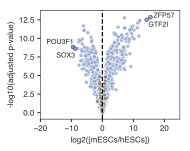

In [56]:
fig, ax = plt.subplots(figsize=(2.5, 2), nrows=1, ncols=1)

ax.scatter(sig["logFC"], 
           sig["neg_log_padj"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=15, 
           linewidths=0.5, edgecolors="white")
ax.scatter(not_sig["logFC"], 
           not_sig["neg_log_padj"],
           color="gray", alpha=0.9, s=15, 
           linewidths=0.5, edgecolors="white")

# annotate top genes
ZFP57 = sig[sig["gene_name_human"] == "ZFP57"].iloc[0]
GTF2I = sig[sig["gene_name_human"] == "GTF2I"].iloc[0]
POU3F1 = sig[sig["gene_name_human"] == "POU3F1"].iloc[0]
SOX3 = sig[sig["gene_name_human"] == "SOX3"].iloc[0]

ax.scatter(ZFP57["logFC"], ZFP57["neg_log_padj"], color=sns.color_palette("Set2")[2], alpha=0.75, s=15,
           linewidths=0.5, edgecolors="black")
ax.text(ZFP57.logFC+0.99, ZFP57.neg_log_padj+0.2, "ZFP57", ha="left", va="center", fontsize=fontsize-1)

ax.scatter(GTF2I["logFC"], GTF2I["neg_log_padj"], color=sns.color_palette("Set2")[2], alpha=0.75, s=15,
           linewidths=0.5, edgecolors="black")
ax.text(GTF2I.logFC+0.55, GTF2I.neg_log_padj-0.25, "GTF2I", ha="left", va="top", fontsize=fontsize-1)

ax.scatter(POU3F1["logFC"], POU3F1["neg_log_padj"], color=sns.color_palette("Set2")[2], alpha=0.75, s=15,
           linewidths=0.5, edgecolors="black")
ax.text(POU3F1.logFC+0.2, POU3F1.neg_log_padj+0.65, "POU3F1", ha="right", va="center", fontsize=fontsize-1)

ax.scatter(SOX3["logFC"], SOX3["neg_log_padj"], color=sns.color_palette("Set2")[2], alpha=0.75, s=15,
           linewidths=0.5, edgecolors="black")
ax.text(SOX3.logFC, SOX3.neg_log_padj-0.5, "SOX3", ha="right", va="top", fontsize=fontsize-1)


ax.set_xlim((-20, 25))
ax.set_xlabel("log2([mESCs/hESCs])")
ax.set_ylabel("-log10(adjusted p-value)")
ax.axvline(x=0, linestyle="dashed", color="black")


fig.savefig("TF_human_v_mouse_volcano.pdf", dpi="figure", bbox_inches="tight")

## 6. write files

In [57]:
orth_tf_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
0,ENSG00000142611,PRDM16,55.601719,ENSMUSG00000039410,Prdm16,612.953260,2.510447,4.964306,1.771139e-10,sig,9.751747
1,ENSG00000078900,TP73,117.897387,ENSMUSG00000029026,Trp73,239.674040,2.530112,2.552952,4.216300e-07,sig,6.375069
2,ENSG00000173673,HES3,272.208698,ENSMUSG00000028946,Hes3,0.000000,-1.119951,-7.611337,1.590728e-10,sig,9.798404
3,ENSG00000204859,ZBTB48,1251.437325,ENSMUSG00000028952,Zbtb48,342.804146,4.430457,-0.387987,5.686419e-02,not sig,1.245161
4,ENSG00000125945,ZNF436,136.434616,ENSMUSG00000051351,Zfp46,177.665949,2.222969,1.836888,4.656334e-06,sig,5.331956


In [58]:
orth_tf_expr[orth_tf_expr["gene_name_human"] == "ZNF524"]

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,AveExpr,logFC,adj.P.Val,sig,neg_log_padj
679,ENSG00000171443,ZNF524,94.867997,ENSMUSG00000051184,Zfp524,81.338313,1.300505,1.249065,0.000547,sig,3.261989


In [59]:
orth_tf_expr_f = "../../../data/03__rna_seq/04__TF_expr/orth_TF_expression.txt"
orth_tf_expr.to_csv(orth_tf_expr_f, sep="\t", index=False)

In [60]:
hESC_TFs = hESC_TFs[["index", "gene_name", "mean_tpm"]].drop_duplicates()
len(hESC_TFs)

1195

In [61]:
hESC_TF_expr_f = "../../../data/03__rna_seq/04__TF_expr/hESC_TF_expression.txt"
hESC_TFs.to_csv(hESC_TF_expr_f, sep="\t", index=False)

In [62]:
mESC_TFs = human_mouse_TFs[["gene_id_human", "gene_name_human", "gene_id_mouse", "gene_name_mouse", "mean_tpm_mouse"]].drop_duplicates()
len(mESC_TFs)

1032

In [63]:
mESC_TF_expr_f = "../../../data/03__rna_seq/04__TF_expr/mESC_TF_expression.txt"
mESC_TFs.to_csv(mESC_TF_expr_f, sep="\t", index=False)

### supplemental file

In [64]:
len(orth_tf_expr)

661

In [65]:
supp_table = orth_tf_expr[["gene_name_human", "gene_name_mouse", "gene_id_human", "gene_id_mouse",
                           "mean_tpm_human", "mean_tpm_mouse", "logFC", "adj.P.Val"]]
supp_table.columns = ["gene_name_human", "gene_name_mouse", "gene_id_human", "gene_id_mouse",
                      "mean_tpm_hESCs", "mean_tpm_mESCs", "logFC", "padj"]

In [66]:
supp_table.to_csv("../../../data/03__rna_seq/04__TF_expr/SuppTable_TFs.txt", sep="\t", index=False)